In [478]:
import numpy as np
from enum import Enum


class Kernel(Enum):
    POLYNOMIAL_KERNEL = "polynomial",
    NONE = "none"# add mode kernels here

class SVM:
    def __init__(self, C = 1.0, kernel = Kernel.NONE) -> None:
        self.C = C # regularization parameter
        self.kernel = kernel # kernel function

    def computeDotProduct(self, w: np.array, b: float, x: np.array, y: float) -> float:
        return 1 - y * self.computePrediction(w,b,x)

    def computePrediction(self, w: np.array, b: float, x: np.array) -> float:
        return np.dot(w,x.T) + b
    
    def polynomialKernel(self, x: np.array, degree: int = 2) -> np.array:
        x = np.c_[ x, np.zeros(x.shape[0]) ] 
        for i in range(x.shape[0]): # basically implement  kernel function
            x[i][2] = x[i][0] * x[i][1]
            # x[i][3] = x[i][0] ** 2
            x[i][0] = x[i][0] ** 2
            x[i][1] = x[i][1] ** 2
            # x[i][4] = x[i][1] ** 2

        return x
    
    def kernelToFunction(kernel: Kernel) -> callable:
        return None # fix later

    def hingeloss(self, w: np.array, b: float, x: np.ndarray, y: np.array) -> float:
        # check if the dimensions are correct
        regularizer: float = 0.5 * np.linalg.norm(w) ** 2
        loss: float = regularizer
        for i in range(x.shape[0]):
            optimizationTerm: float = self.computeDotProduct(w,b,x[i],y[i]) # since the w and x are vectors, horizontal ones, we need to transpose x
            loss += self.C * max(0,optimizationTerm)
        return loss
    
    def __fit(self, X: np.ndarray, Y: np.ndarray, batchSize: int = 100, learningRate: float = 0.001, epochs: int = 1000) -> (np.array, float,  list):
        if self.kernel == Kernel.POLYNOMIAL_KERNEL:
            X = self.polynomialKernel(X)
        
        numberOfFeatures: int = X.shape[1]
        numberOfSamples: int = X.shape[0]
        ids = np.arange(numberOfSamples) # ids of the samples
        np.random.shuffle(ids) # shuffle the ids
        w: np.array = np.zeros((1,numberOfFeatures))[0]
        b: float = 0
        losses: list = []

        for _ in range(epochs):
            loss = self.hingeloss(w,b,X,Y)
            losses.append(loss)

            for batchInitial in range(0,numberOfSamples,batchSize):
                gradW: float = 0
                gradB: float = 0
                for j in range (batchInitial, batchInitial + batchSize):
                    if j < numberOfSamples:
                        optimizationTerm: float = self.computeDotProduct(w,b,X[ids[j]],Y[ids[j]])
                        if optimizationTerm > 0:
                            gradW += self.C * Y[ids[j]] * X[ids[j]]
                            gradB += self.C * Y[ids[j]]
                w = w - learningRate * w + learningRate * gradW
                b = b + learningRate * gradB
        return w,b,losses

    def fit(self, X: np.ndarray, Y: np.ndarray, batchSize: int = 100, learningRate: float = 0.001, epochs: int = 1000) -> (np.array, float,  list):
        classes: int = len(np.unique(Y))
        w: np.array = np.zeros((classes,X.shape[1]))
        b: np.array = np.zeros(classes)
        losses: list = []

        if classes == 2:
            yTemp = np.copy(Y)
            yTemp[yTemp != 1] = -1
            yTemp[yTemp == 1] = 1
            w, b, loss = self.__fit(X,yTemp,batchSize=batchSize,learningRate=learningRate,epochs=epochs)
            losses.append(loss)
            return w,b,losses
        
        for i in range(classes):
            print(i+1,"'th class out of ", classes)
            yTemp = np.copy(Y)
            yTemp[yTemp != i] = -1
            yTemp[yTemp == i] = 1
            w[i], b[i], loss = self.__fit(X,yTemp,batchSize=batchSize,learningRate=learningRate,epochs=epochs)
            losses.append(loss)

        return w,b, losses

    def predict(self, X: np.ndarray, w: np.ndarray, b: float) -> np.array:
        if self.kernel == Kernel.POLYNOMIAL_KERNEL:
            X = self.polynomialKernel(X)
        if w.ndim > 1:
            prediction = np.matmul(X,w.T) +b 
            return np.argmax(prediction,axis=1)
        else:
            prediction = self.computePrediction(w,b,X)
            return np.sign(prediction)
        
    def accuracy(self, X: np.ndarray, Y: np.ndarray, w: np.ndarray, b: float) -> float:
        predictions = self.predict(X,w,b)
        return np.mean(predictions == Y)
    
    def printStatistics(self, X: np.ndarray, Y: np.ndarray, w: np.array, b: np.array, loss: list) -> None:
        print("Accuracy: ", self.accuracy(X,Y,w,b))
        print("Loss: ", loss)
        print("predict:", self.predict(X,w,b))
        print("w:", w)
        print("b: ", b)
        

$$\min {\frac {1}{2} \|w\|^2} + C_i \cdot \sum_{i=1}^n \max{\{0,1-y_n(w^Tx+b)\}}$$

In [479]:
svm = SVM()
# print(SVM.hingeloss(np.array([1,2]),1,np.array([[1,2],[3,4],[5,6]]),np.array([1,-1,1])))
w, b, losses = svm.fit(np.array([[1,2],[3,4],[5,6]]),np.array([1,-1,1]))
print(w,b,losses)
print(svm.predict(np.array([[1,2],[3,4],[5,6]]),w,b))

[-0.07281361  0.16554549] 0.3840000000000003 [[3.0, 2.9740124999999997, 2.9480749500125, 2.922187250187425, 2.8963493008743004, 2.8705610026218524, 2.8448222561776118, 2.8191329624875126, 2.7934930226955004, 2.7679023381431316, 2.742360810369183, 2.7168683411092553, 2.691424832295378, 2.66603018605562, 2.6406843047136945, 2.6153870907885715, 2.590138446994086, 2.5649382762385446, 2.5397864816243434, 2.5146829664475767, 2.4896276341976478, 2.4646203885568863, 2.439661133400161, 2.414749772794494, 2.3898862109986783, 2.365070352462892, 2.3677279213347853, 2.3589968332200373, 2.3688372292571565, 2.3645499729598516, 2.3583282047632492, 2.3700959694497827, 2.3613601476068524, 2.3621092974489306, 2.3669109276949634, 2.358181472750501, 2.3658776486023445, 2.3637370157475326, 2.3553693151158743, 2.369285407601799, 2.360551206072003, 2.3591518606807713, 2.3661043680380343, 2.357376525406326, 2.362921650926208, 2.3629344368730316, 2.3542129309337225, 2.3666787146356807, 2.35977557138958, 2.35615

In [480]:
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# Creating dataset
X, y = datasets.make_blobs(
        n_samples = 100, # Number of samples
        n_features = 2, # Features
        centers = 2,
        cluster_std = 1,
        random_state=41
    )

# Classes 1 and -1
y = np.where(y == 0, -1, 1)

In [481]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

svm = SVM()

w, b, losses = svm.fit(X_train, y_train)

loss = losses.pop()

svm.printStatistics(X_test,y_test, w,b,loss)
# print("X_test", X_test)
# print("y_test", y_test)

Accuracy:  1.0
Loss:  [50.0, 6.767087400000403, 2.080904903093642, 4.149100563549742, 1.5521803467670656, 0.27779231866002513, 0.0989478671035527, 0.09875007031721271, 0.0985526689266486, 0.09835566214146425, 0.09815904917284346, 0.09796282923354693, 0.09776700153790907, 0.09856097777046771, 0.09840864269364481, 0.09821192381690022, 0.09801559818119022, 0.09781966500042602, 0.09762412349009018, 0.0974289728672335, 0.0972342123504719, 0.09703984115998332, 0.0968458585175045, 0.09665226364632803, 0.09645905577129901, 0.09626623411881217, 0.09607379791680869, 0.095881746394773, 0.09569007878372983, 0.09549879431624116, 0.09530789222640297, 0.09511737174984239, 0.09492723212371448, 0.09473747258669916, 0.09454809237899836, 0.09435909074233274, 0.09417046691993881, 0.09398222015656588, 0.09379434969847289, 0.09360685479342565, 0.09341973469069358, 0.09323298864104687, 0.09304661589675345, 0.09286061571157583, 0.09267498734076836, 0.09248973004107418, 0.09230484307072208, 0.0921203256894237,

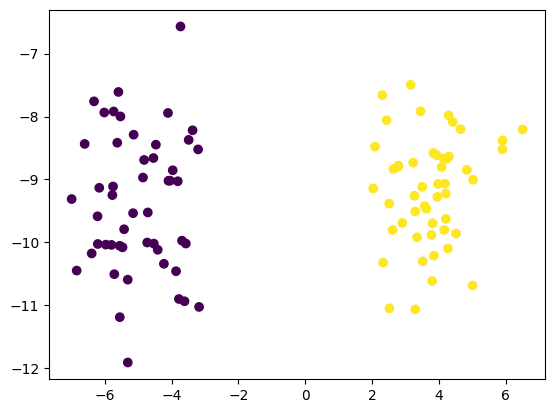

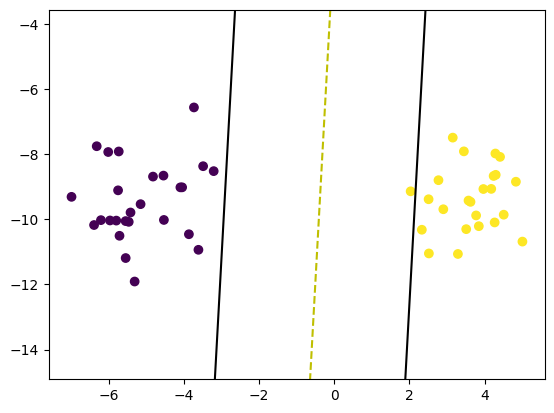

In [482]:
# Visualizing the scatter plot of the dataset
def visualize_dataset(X: np.ndarray = X, y: np.ndarray = y):
    plt.scatter(X[:, 0], X[:, 1], c=y)


# Visualizing SVM
def visualize_svm(w: np.array,b: float, X: np.ndarray, XTest: np.ndarray, yTest: np.ndarray):
    # split w to w and b where b is first element of w
    # b = w[0]
    # w = w[1:] 

    def get_hyperplane_value(x, w, b, offset):
        return (-w[0] * x + b + offset) / w[1]

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    plt.scatter(XTest[:, 0], XTest[:, 1], marker="o", c=yTest)

    x0_1 = np.amin(XTest[:, 0])
    x0_2 = np.amax(XTest[:, 0])

    x1_1 = get_hyperplane_value(x0_1, w, b, 0)
    x1_2 = get_hyperplane_value(x0_2, w, b, 0)

    x1_1_m = get_hyperplane_value(x0_1, w, b, -1)
    x1_2_m = get_hyperplane_value(x0_2, w, b, -1)

    x1_1_p = get_hyperplane_value(x0_1, w, b, 1)
    x1_2_p = get_hyperplane_value(x0_2, w, b, 1)

    ax.plot([x0_1, x0_2], [x1_1, x1_2], "y--")
    ax.plot([x0_1, x0_2], [x1_1_m, x1_2_m], "k")
    ax.plot([x0_1, x0_2], [x1_1_p, x1_2_p], "k")

    x1_min = np.amin(X[:, 1])
    x1_max = np.amax(X[:, 1])
    ax.set_ylim([x1_min - 3, x1_max + 3])

    plt.show()


visualize_dataset(X, y)
visualize_svm(w, b, X, X_test, y_test)

Kernels

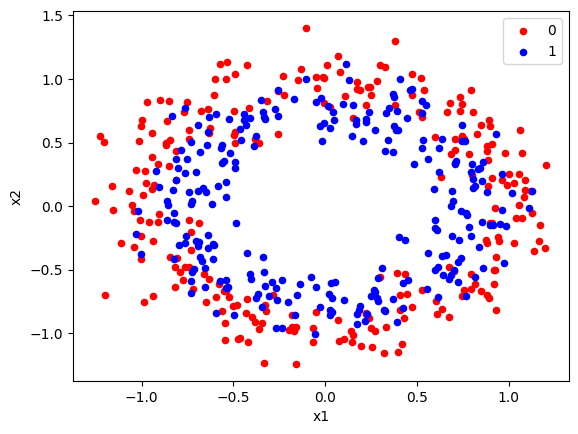

In [483]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=500, noise=0.13, random_state=42)

df = pd.DataFrame(dict(x1=X[:, 0], x2=X[:, 1], y=y))

colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('y')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x1', y='x2', label=key, color = colors[key])
plt.show()

In [484]:
y[y == 0] = -1 # change to -1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

svm = SVM()

w, b, losses = svm.fit(X_train, y_train)

# Loss value
loss = losses.pop()

svm.printStatistics(X_test,y_test,w,b,loss)

Accuracy:  0.476
Loss:  [250.0, 249.85489902861536, 249.70980244604, 249.5647102326016, 249.41962236872655, 249.27453883493735, 249.12945961185488, 248.98438468019532, 248.83931402077144, 248.69424761449085, 248.5491854423567, 248.4041274854654, 248.25907372500834, 248.11402414226964, 247.96897871862654, 247.82393743554766, 247.67890027459512, 247.53386721742106, 247.38883824576925, 247.24381334147364, 247.09879248645694, 246.9537756627333, 246.8087628524044, 246.66375403766048, 246.5187492007805, 246.37374832412985, 246.2287513901619, 246.0837583814163, 245.93876928051858, 245.79378407018024, 245.64880273319753, 245.50382525245186, 245.35885161090863, 245.21388179161778, 245.0689157777112, 244.92395355240527, 244.77899509899785, 244.63404040086948, 244.4890894414818, 244.34414220437824, 244.19919867318222, 244.0542588315981, 243.90932266340982, 243.76439015248107, 243.61946128275454, 243.47453603825087, 243.32961440307025, 243.18469636138911, 243.03978189746252, 242.8948709956218, 242

In [485]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

svm = SVM(kernel=Kernel.POLYNOMIAL_KERNEL)

w, b, losses = svm.fit(X_train, y_train)
loss = losses.pop()

svm.printStatistics(X_test,y_test,w,b,loss)

Accuracy:  0.772
Loss:  [250.0, 248.15957511471203, 246.32592185138893, 244.4990098161412, 242.67880876661528, 240.8652886111756, 239.05841940809592, 237.25817136475075, 235.4645148368129, 233.67742032745838, 231.89685848657035, 230.1228001099517, 228.35521613854124, 226.59407765763362, 224.83935589610317, 223.17450094588742, 221.69190988662788, 220.51004726967707, 219.4861788243143, 218.65832036679112, 218.03329356497193, 217.57213262086745, 217.14155317609914, 216.76024222734648, 216.39706700943762, 216.05544154293312, 215.7199001306252, 215.38534948610942, 215.05178527602595, 214.72576760946964, 214.40065530071547, 214.07644445129628, 213.75313118152076, 213.43857063948326, 213.12482188458378, 212.8136314855125, 212.5034020447747, 212.19393548553873, 211.8852285471241, 211.57727798445512, 211.27008056797698, 210.96363308357593, 210.65804942491414, 210.35328307740633, 210.04922357247418, 209.74586785747945, 209.4432128945254, 209.14125566037706, 208.83999314638467, 208.53942235840722

In [486]:
import plotly.express as px

df['x1^2'] = df['x1'] ** 2
df['x2^2'] = df['x2'] ** 2
df['x1 * x2'] = df['x1'] * df['x2']
df['x1^2 + x2^2'] = df['x1'] ** 2 + df['x2'] **2

fig = px.scatter_3d(df, x='x1', y='x2', z='x1 * x2', color='y')
fig.show()

In [487]:
fig = px.scatter_3d(df, x='x1^2', y='x2^2', z='x1 * x2', color='y')
fig.show()

In [488]:
fig = px.scatter_3d(df, x='x1', y='x2', z='x1^2 + x2^2', color='y')
fig.show()

In [489]:
# lets imagine we want to classify n classes from a data set
# we can use one vs rest method
# basically we will train n different classifiers, one for each class

from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

svm = SVM()
w,b,losses = svm.fit(X_train,y_train)

svm.printStatistics(X_test,y_test,w,b,losses.pop())
print(losses)


1 'th class out of  3
2 'th class out of  3
3 'th class out of  3
Accuracy:  0.8666666666666667
Loss:  [105.0, 80.00287080920053, 80.30287816777769, 78.91847081267382, 117.91662353419397, 121.76562919447744, 66.96885123346868, 62.385883689465764, 58.55102855211975, 55.00578833470764, 54.06736801574492, 53.102958575044575, 52.579314000037265, 54.54460624899444, 51.36135090115795, 50.73819452543905, 53.1624098968369, 49.477091799733095, 48.78975407721097, 50.76708718319234, 47.63680256513863, 46.817764360730756, 48.365956652315575, 45.532547199056786, 44.88409963201889, 45.43225231255691, 43.85513073720046, 44.03116448317304, 42.381258138599726, 42.150672838864196, 41.40618938696352, 41.71120304856272, 40.025123741859005, 39.58252056009441, 38.89242296641938, 38.346889561560715, 38.00187735229422, 37.38933196780203, 37.8477179726143, 36.80178621621578, 40.97243066175415, 49.94140050289381, 66.94931335931034, 65.55025118188135, 56.95707717932903, 69.04508294674025, 52.690967472559386, 70.

In [490]:
# lets imagine we want to classify n classes from a data set
# we can use one vs rest method
# basically we will train n different classifiers, one for each class

from sklearn.datasets import load_digits

iris = load_digits()
X = iris.data
y = iris.target
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

svm = SVM()
w,b,losses = svm.fit(X_train,y_train)

svm.printStatistics(X_test,y_test,w,b,losses.pop())
print(losses)

(1797, 64)
1 'th class out of  10
2 'th class out of  10
3 'th class out of  10
4 'th class out of  10
5 'th class out of  10
6 'th class out of  10
7 'th class out of  10
8 'th class out of  10
9 'th class out of  10
10 'th class out of  10
Accuracy:  0.9222222222222223
Loss:  [1257.0, 461.56154127901937, 206.82208382920263, 123.5231271806994, 143.55680381703934, 100.81739296273437, 82.69797606606959, 129.1908678794536, 72.46536229171706, 67.53310655852088, 100.7461787813764, 69.92354893689748, 56.09162077606226, 61.44247943690011, 69.2332618842793, 67.1581514218692, 51.28326646321843, 65.29900541816662, 58.00324365569028, 50.528698696913146, 125.77922474948268, 67.78073965792687, 50.90130616939463, 60.7519279570854, 78.45442274173254, 41.19720330512448, 60.84779396937272, 40.851450835903776, 67.80704024859833, 38.59586775715549, 38.31494976094836, 46.61318381200676, 33.7361061053912, 38.56018674357277, 35.93271006543006, 107.72750266438152, 255.9564504116005, 107.12014861247665, 98.8

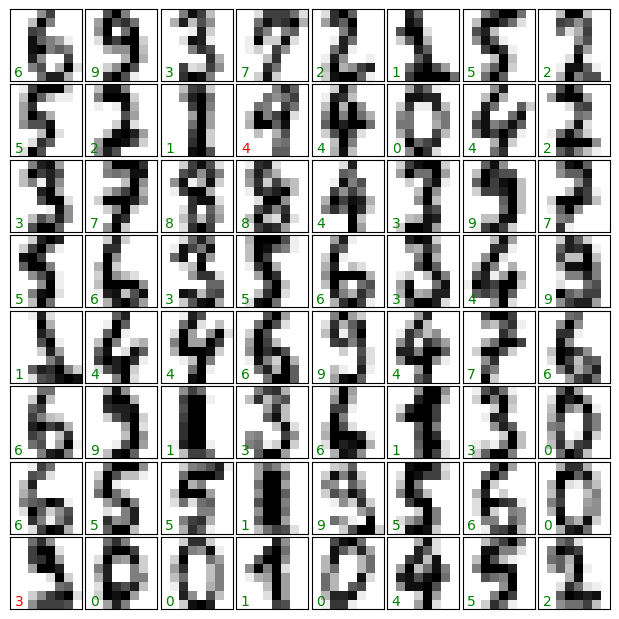

In [492]:
predicted = svm.predict(X_test,w,b)

fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(X_test.reshape(-1, 8, 8)[i], cmap=plt.cm.binary,
              interpolation='nearest')

    # label the image with the target value
    if predicted[i] == y_test[i]:
        ax.text(0, 7, str(predicted[i]), color='green')
    else:
        ax.text(0, 7, str(predicted[i]), color='red')